In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
import pandas as pd
import geopandas as gp
import numpy as np
from statistics import mean, median
import requests

**Load data**

In [2]:
#Census VTD
vtd = gp.read_file("./raw-from-source/tl_2012_42_vtd10/tl_2012_42_vtd10.shp")

#Census block
blocks = gp.read_file("./raw-from-source/tl_2010_42_tabblock10/tl_2010_42_tabblock10.shp")

**Clean shapefiles**

In [3]:
# Remove undefined area (north-west corner of state) in Census VTD shapefile
vtd = vtd[vtd.NAME10!="Voting Districts not defined"]

In [4]:
from block_remove import block_remove
# remove weird blocks from north-west corner
new_geos = [n for n in blocks.GEOID10 if n not in block_remove]
blocks = blocks[blocks['GEOID10'].isin(new_geos)]

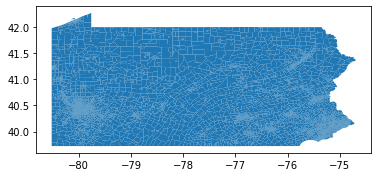

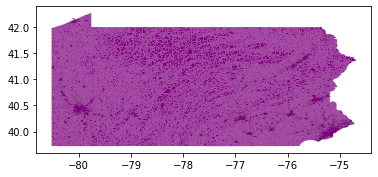

In [5]:
vtd.plot()
blocks.plot(color='purple')

**Get demographic data from Census API**

In [6]:
#code chunk by Melisande Teng - VRDI 2019

variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]


def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [7]:
## retrieve data from Census API
# demo_data = block_data_for_state('42')

## save API demographic data to csv
# demo_data.to_csv("./raw-from-source/blk10_demo_pa.csv")

In [8]:
demo_data = pd.read_csv("./raw-from-source/blk10_demo_pa.csv")

In [9]:
demo_data.head()

,Unnamed: 0,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,GEOID10
0,0,21,21,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1010, Block Group 1, Census Tract 1101, ...",42,39,110100,1010,420391101001010
1,1,30,29,1,0,0,0,0,0,0,...,0,0,0,0,"Block 1004, Block Group 1, Census Tract 1101, ...",42,39,110100,1004,420391101001004
2,2,4,4,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1030, Block Group 1, Census Tract 1101, ...",42,39,110100,1030,420391101001030
3,3,14,14,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1011, Block Group 1, Census Tract 1101, ...",42,39,110100,1011,420391101001011
4,4,15,15,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1013, Block Group 1, Census Tract 1101, ...",42,39,110100,1013,420391101001013


In [10]:
demo_data = demo_data.rename(columns={'geoid': 'GEOID10'})

In [11]:
demo_data.GEOID10 = demo_data.GEOID10.astype(str)

In [12]:
# Join block-level shapefile with block-level demographic data
blk_joined = pd.merge(blocks, demo_data, on='GEOID10', how='left')

In [13]:
# Check join with state population
blk_joined.TOTPOP.sum()

12702113

### Aggregate blocks to VTDs

In [14]:
variables = ['TOTPOP','NH_WHITE', 'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN', 'NH_NHPI ', 'NH_OTHER',
       'NH_2MORE', 'HISP', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

proj = blk_joined.crs
blk_joined = blk_joined.to_crs(proj)

pieces = maup.assign(blk_joined, vtd)

In [15]:
vtd[variables] = blk_joined[variables].astype(float).groupby(pieces).sum()

vtd.sort_values("GEOID10")[['GEOID10', 'NAME10', 'VAP']]

,GEOID10,NAME10,VAP
9254,4200110,ABBOTTSTOWN,752.0
9251,42001100,CONEWAGO TWP VTD 02,3091.0
9246,42001110,CUMBERLAND TWP VTD 01,1462.0
9239,42001120,CUMBERLAND TWP VTD 02,1183.0
9245,42001130,CUMBERLAND TWP VTD 03,1787.0
...,...,...,...
1415,42133950,SPRINGFIELD TWP Voting District,3959.0
1416,42133960,STEWARTSTOWN Voting District,1504.0
1417,42133970,WARRINGTON TWP Voting District,3695.0
1418,42133980,WASHINGTON TWP Voting District,2076.0


In [16]:
vtd.TOTPOP.sum()

12702113.0

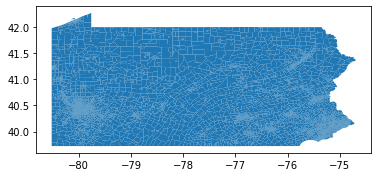

In [17]:
vtd.plot()

### Load Election Data

**2010**

In [18]:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/16389 
# Harvard Election Data Archive
pa_2010 = gp.read_file("./raw-from-source/PA_Shapefile/pa_final.shp")

In [19]:
# Remove undefined area (north-west corner of state) in election VTD shapefile
pa_2010 = pa_2010[pa_2010.NAME10!="Voting Districts not defined"]

In [20]:
pa_2010 = pa_2010[['PA_GEO_ID', 'GEOID10','PA_VOTE_ID','NAME10',
          'GOVDV2010', 'GOVRV2010', "USSDV2010", "USSRV2010"]]

In [21]:
df10 = pd.merge(vtd, pa_2010, on=['GEOID10',"NAME10"] , how='left')

In [22]:
df10[['GOVDV2010', 'GOVRV2010', "USSDV2010", "USSRV2010"]]

,GOVDV2010,GOVRV2010,USSDV2010,USSRV2010
0,289.0,349.0,315.0,328.0
1,28.0,125.0,35.0,116.0
2,42.0,201.0,52.0,193.0
3,66.0,139.0,76.0,134.0
4,178.0,364.0,197.0,340.0
...,...,...,...,...
9250,308.0,935.0,358.0,875.0
9251,186.0,833.0,218.0,797.0
9252,202.0,689.0,240.0,650.0
9253,67.0,186.0,85.0,169.0


### 2012

In [23]:
# https://github.com/openelections/openelections-data-pa/tree/master/2012 
# Open Elections
pa_2012 = pd.read_csv("./raw-from-source/20121106__pa__general__precinct.csv")

In [24]:
pa_2012.county = pa_2012.county.astype(str)
pa_2012['county_nstr'] = pa_2012.county.str.zfill(3)

In [25]:
pa_2012['GEOID10'] = '42' + pa_2012.county_nstr.astype(str) + pa_2012.precinct.astype(str)

In [26]:
# subset data to offices of interest
pa_2012 = pa_2012[(pa_2012.position=="USP")|(pa_2012.position=="USS")|(pa_2012.position=="ATT")]

In [27]:
pa_2012 = pa_2012[pa_2012["c_first"].notnull()]

**Fix county fip codes to actual county fip codes**

In [28]:
# Number of observations for each county
n_county_ob_2012 = list(pa_2012.groupby("county_nstr").count()["year"])

# Pennsylvania county fips codes
pa_counties = [i for i in range(0,134) if i % 2 == 1]

In [29]:
county_fips12 = []
for i,j in zip(pa_counties, n_county_ob_2012):
    new_fips = [i]*j
    county_fips12.append(new_fips)
    
#flatten list
county_fips12 = [item for sublist in county_fips12 for item in sublist]  

In [30]:
pa_2012['county_fips'] = county_fips12
pa_2012['county_fips'] = pa_2012.county_fips.astype(str)
pa_2012['county_fips'] = pa_2012.county_fips.str.zfill(3)

In [31]:
# Replace original GEOID with one that includes proper county fip codes
pa_2012['GEOID10'] = '42' + pa_2012.county_fips.astype(str) + pa_2012.vtd.astype(str)

In [32]:
# Add NAME column for manual matching later
pa_2012['NAME'] = pa_2012.municipality.astype(str) + ' '+ pa_2012.mcode1.astype(str) + ' ' + pa_2012.mname1.astype(str) + ' ' + pa_2012.mcode2.astype(str)+' '  +pa_2012.mname2.astype(str) 

In [33]:
pa_2012.sort_values("GEOID10")

,year,elec_type,county,precinct,c_off_rank,c_party_rank,c_ballot_pos,c_off_ocde,position,party,...,fips,vtd,past_precinct,past_cd,past_sentate_d,past_hd,county_nstr,GEOID10,county_fips,NAME
0,2012,G,1,10,1,0,1,2,USP,REP,...,1,10,0,19,33,91,001,4200110,001,ABBOTTSTOWN nan nan nan nan
539,2012,G,1,10,5,0,8,99,ATT,LIB,...,1,10,0,19,33,91,001,4200110,001,ABBOTTSTOWN nan nan nan nan
147,2012,G,1,10,1,0,8,99,USP,LIB,...,1,10,0,19,33,91,001,4200110,001,ABBOTTSTOWN nan nan nan nan
49,2012,G,1,10,1,0,2,1,USP,DEM,...,1,10,0,19,33,91,001,4200110,001,ABBOTTSTOWN nan nan nan nan
245,2012,G,1,10,3,0,1,4,USS,REP,...,1,10,0,19,33,91,001,4200110,001,ABBOTTSTOWN nan nan nan nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202476,2012,G,67,990,5,0,1,1,ATT,REP,...,133,990,0,19,33,92,067,42133990,133,WELLSVILLE nan nan nan nan
202794,2012,G,67,990,5,0,8,99,ATT,LIB,...,133,990,0,19,33,92,067,42133990,133,WELLSVILLE nan nan nan nan
201599,2012,G,67,990,1,0,8,99,USP,LIB,...,133,990,0,19,33,92,067,42133990,133,WELLSVILLE nan nan nan nan
202635,2012,G,67,990,5,0,2,1,ATT,DEM,...,133,990,0,19,33,92,067,42133990,133,WELLSVILLE nan nan nan nan


In [34]:
# Reshape data
pa_12 = pa_2012.pivot_table(index=['municipality','NAME',"GEOID10"], columns=['party','position'], values='vote_tot')

In [35]:
# Fix index
pa_12.reset_index(drop=False, inplace=True)
pa_12.index.names = ['ind']
pa_12.columns.names = ['office','column']

In [36]:
# Fix column names
pa_12.columns = ['_'.join(col).strip() for col in pa_12.columns.values]
pa_12 = pa_12.rename(columns={"GEOID10_": "GEOID10", "municipality_": "municipality", "NAME_":"NAME"})

In [37]:
# Handle duplictes
pa_12 = pa_12.groupby(['GEOID10'], as_index=False).agg({'municipality': 'first', 'NAME': 'first', 
                                             'DEM_ATT':"sum", 'DEM_USP':"sum", 'DEM_USS':"sum",                                
                                             'GRN_USP':"sum", 'LIB_ATT':"sum", 'LIB_USP':"sum", 
                                             'LIB_USS':"sum", 'REP_ATT':"sum", 'REP_USP':"sum",
                                             'REP_USS':"sum"})


In [38]:
pa_12.shape[0]

9213

In [39]:
# Join third-party votes
pa_12['THIRD_USP12'] = pa_12["GRN_USP"] + pa_12["LIB_USP"]
pa_12['THIRD_ATT12'] = pa_12["LIB_ATT"] 
pa_12['THIRD_USS12'] = pa_12["LIB_USS"] 

pa_12 = pa_12.drop(["GRN_USP","LIB_USP", "LIB_ATT", "LIB_USS"],axis=1)

In [40]:
# Add year to the end of variable names
edit_var = ['DEM_ATT', 'DEM_USP', 'DEM_USS','REP_ATT', 'REP_USP', 'REP_USS']
new_var = [var+"12" for var in edit_var]
renaming = {edit_var[i]: new_var[i] for i in range(len(new_var))} 
pa_12 = pa_12.rename(columns=renaming)

In [41]:
pa_12.head()

,GEOID10,municipality,NAME,DEM_ATT12,DEM_USP12,DEM_USS12,REP_ATT12,REP_USP12,REP_USS12,THIRD_USP12,THIRD_ATT12,THIRD_USS12
0,4200110,ABBOTTSTOWN,ABBOTTSTOWN nan nan nan nan,136.0,129.0,131.0,178.0,195.0,190.0,8.0,8.0,7.0
1,42001100,CONEWAGO,CONEWAGO X 2 nan nan,676.0,550.0,589.0,944.0,1107.0,1051.0,20.0,35.0,28.0
2,42001110,CUMBERLAND,CUMBERLAND X 1 nan nan,502.0,455.0,486.0,502.0,584.0,529.0,4.0,21.0,18.0
3,42001120,CUMBERLAND,CUMBERLAND X 2 nan nan,293.0,243.0,256.0,407.0,471.0,453.0,10.0,23.0,20.0
4,42001130,CUMBERLAND,CUMBERLAND X 3 nan nan,570.0,510.0,527.0,601.0,685.0,660.0,14.0,30.0,22.0


In [42]:
pa_12[["DEM_USP12","REP_USP12"]].sum()

DEM_USP12    2985161.0
REP_USP12    2672660.0
dtype: float64

In [43]:
## Manually match majority of remaining VTDs
from match_vtds import match_vtds 
pa_12_matched = match_vtds(pa_12)

df12 = pd.merge(df10, pa_12_matched, on="GEOID10", how="left", indicator=True)

**98% of 2012 VTD election data joined**

In [44]:
df12[df12["_merge"]=="both"].shape[0] / vtd.shape[0]

0.9837925445705025

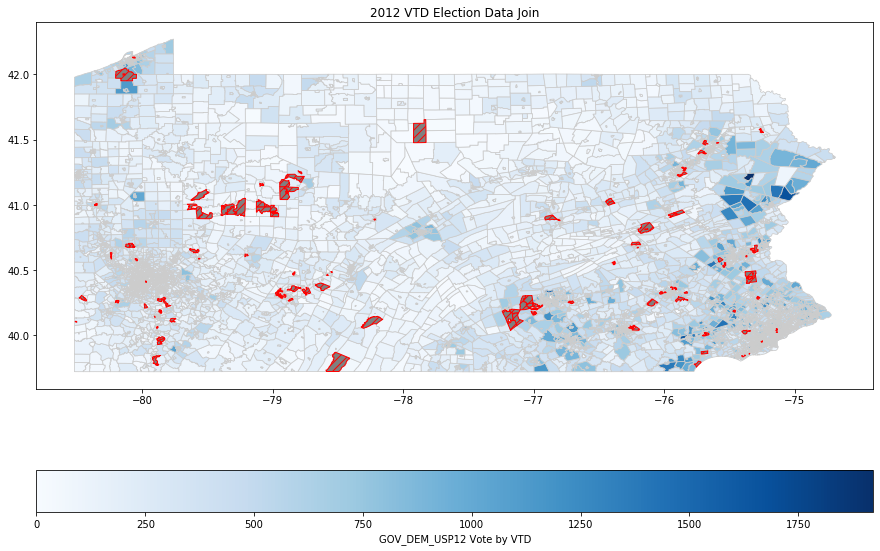

In [45]:
ax = df12[df12.DEM_USP12.notna()].plot(column='DEM_USP12', figsize=(15, 10), cmap='Blues', edgecolor='0.8', linewidth=0.8, 
                           legend=True, legend_kwds={'label': "GOV_DEM_USP12 Vote by VTD",
                                                     'orientation': "horizontal"})

df12[df12.DEM_USP12.isna()].plot(color='grey', hatch='///', ax=ax, edgecolor="red",
                     legend_kwds={'label': "Missing Data",
                                                     'orientation': "horizontal"})
plt.title("2012 VTD Election Data Join");

In [46]:
df12.head()

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,...,DEM_ATT12,DEM_USP12,DEM_USS12,REP_ATT12,REP_USP12,REP_USS12,THIRD_USP12,THIRD_ATT12,THIRD_USS12,_merge
0,42,085,960,42085960,A,SHENANGO TWP VTD WEST,SHENANGO TWP VTD WEST,00,G5240,N,...,514.0,492.0,505.0,388.0,451.0,423.0,5.0,23.0,16.0,both
1,42,039,40,4203940,A,BLOOMING VALLEY Voting District,BLOOMING VALLEY Voting District,00,G5240,N,...,57.0,51.0,45.0,124.0,127.0,136.0,9.0,15.0,8.0,both
2,42,039,10,4203910,A,ATHENS TWP Voting District,ATHENS TWP Voting District,00,G5240,N,...,68.0,75.0,65.0,215.0,225.0,230.0,4.0,14.0,6.0,both
3,42,039,20,4203920,A,BEAVER TWP Voting District,BEAVER TWP Voting District,00,G5240,N,...,111.0,110.0,112.0,153.0,167.0,160.0,2.0,15.0,11.0,both
4,42,039,30,4203930,A,BLOOMFIELD TWP Voting District,BLOOMFIELD TWP Voting District,00,G5240,N,...,330.0,315.0,268.0,342.0,394.0,436.0,14.0,38.0,18.0,both


### 2014

In [47]:
# https://github.com/openelections/openelections-data-pa/tree/master/2014 
# OpenElections
pa_2014 = pd.read_csv("./raw-from-source/20141104_pa_general_precinct.csv")

In [48]:
pa_2014.county = pa_2014.county.astype(str)
pa_2014['county_nstr'] = pa_2014.county.str.zfill(3)

In [49]:
pa_2014['GEOID10'] = '42' + pa_2014.county_nstr.astype(str) + pa_2014.precinct.astype(str)

In [50]:
pa_2014 = pa_2014[pa_2014.position=="GOV"]

In [51]:
pa_2014["vtd_tot_vote"] = pa_2014.groupby('GEOID10')['vote_tot'].transform(sum)
pa_2014["party_vtd_tot_vote"] = pa_2014.groupby(['GEOID10', 'party'])['vote_tot'].transform(sum)

In [52]:
pa_2014 = pa_2014[pa_2014["c_first"].notnull()]

**Fix county fip codes to actual county fip codes**

In [53]:
n_county_ob_2014 = list(pa_2014.groupby("county_nstr").count()["year"])

In [54]:
county_fips14 = []
for i,j in zip(pa_counties, n_county_ob_2014):
    new_fips = [i]*j
    county_fips14.append(new_fips)
    
#flatten list
county_fips14 = [item for sublist in county_fips14 for item in sublist]  

In [55]:
pa_2014['county_fips'] = county_fips14
pa_2014.county_fips = pa_2014.county_fips.astype(str)
pa_2014['county_fips'] = pa_2014.county_fips.str.zfill(3)

In [56]:
# Replace original GEOID with one that includes proper county fip codes
pa_2014['GEOID10'] = '42' + pa_2014.county_fips.astype(str) + pa_2014.vtd.astype(str)

In [57]:
# Add NAME column for manual matching later
pa_2014['NAME'] = pa_2014.municipality.astype(str) + ' '+ pa_2014.mcode1.astype(str) + ' ' + pa_2014.mname1.astype(str) + ' ' + pa_2014.mcode2.astype(str)+' '  +pa_2014.mname2.astype(str) 

In [58]:
# Reshape data
pa_14 = pa_2014.pivot_table(index=['GEOID10','municipality','NAME'], columns='party', values='vote_tot')

In [59]:
pa_14.reset_index(drop=False, inplace=True)
pa_14.index.names = ['ind']
pa_14.columns.names = ['column']

In [60]:
pa_14 = pa_14.rename(columns={"DEM":"DEM_GOV14", "REP":"REP_GOV14"})

In [61]:
pa_14.shape[0]

9182

In [62]:
pa_14[["DEM_GOV14","REP_GOV14"]].sum()

column
DEM_GOV14    1919428
REP_GOV14    1574567
dtype: int64

In [63]:
## Manually match majority of remaining VTDs
from match_vtds import match_vtds 
pa_14_matched = match_vtds(pa_14)
df12 = df12.drop("_merge", axis=1)

df14 = pd.merge(df12, pa_14_matched, on="GEOID10", how="left", indicator=True)

**97% of 2014 election data match with VTDs**

In [64]:
df14[df14["_merge"]=="both"].shape[0] / vtd.shape[0]

0.9789303079416531

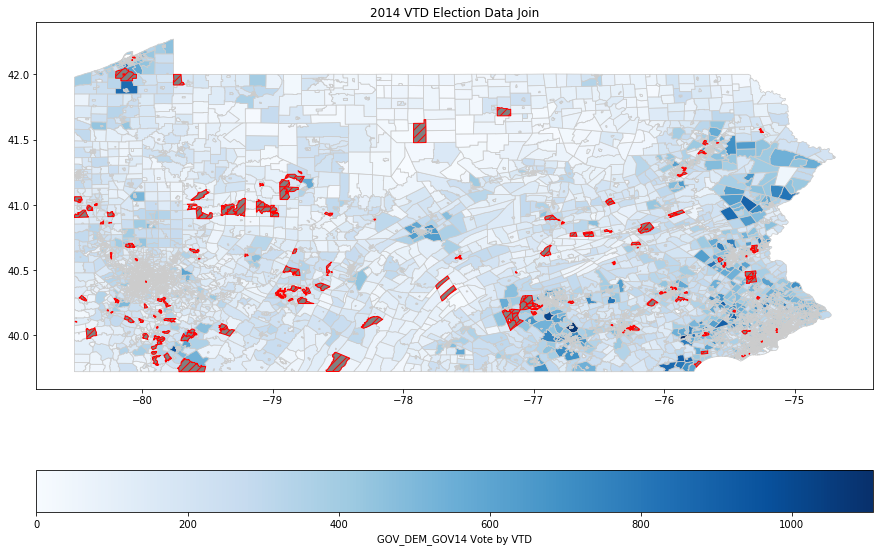

In [65]:
ax = df14[df14.DEM_GOV14.notna()].plot(column='DEM_GOV14', figsize=(15, 10), cmap='Blues', edgecolor='0.8', linewidth=0.8, 
                           legend=True, legend_kwds={'label': "GOV_DEM_GOV14 Vote by VTD",
                                                     'orientation': "horizontal"})

df14[df14.DEM_GOV14.isna()].plot(color='grey', hatch='///', ax=ax, edgecolor="red",
                     legend_kwds={'label': "Missing Data",
                                                     'orientation': "horizontal"})
plt.title("2014 VTD Election Data Join");

**2016**

In [66]:
# https://github.com/openelections/openelections-data-pa/tree/master/2016
# Open Elections
pa_2016 = pd.read_csv("./raw-from-source/20161108__pa__general__precinct.csv")

In [67]:
pa_2016.district = pa_2016.district.astype(str)
pa_2016["NAME"] = pa_2016.county + ' ' + pa_2016.precinct + ' ' + pa_2016.district

In [68]:
pa_2016.county = pa_2016.county.astype(str)

pa_2016['geo_place'] = '42' + pa_2016.county.astype(str) + pa_2016.precinct.astype(str)

In [69]:
# Subset to offices of interest
pa_2016 = pa_2016[(pa_2016.office=='President')|(pa_2016.office=='U.S. Senate')|(pa_2016.office=='Attorney General')]

pa_2016 = pa_2016.replace(to_replace =['President','U.S. Senate', 'Attorney General'],
                             value =["USP","USS","ATT"])

In [70]:
pa_2016.head()

,county,precinct,office,district,candidate,party,votes,NAME,geo_place
0,Adams,ABBOTTSTOWN,USP,nan,HILLARY CLINTON,DEM,119,Adams ABBOTTSTOWN nan,42AdamsABBOTTSTOWN
1,Adams,ARENDTSVILLE,USP,nan,HILLARY CLINTON,DEM,143,Adams ARENDTSVILLE nan,42AdamsARENDTSVILLE
2,Adams,BENDERSVILLE,USP,nan,HILLARY CLINTON,DEM,83,Adams BENDERSVILLE nan,42AdamsBENDERSVILLE
3,Adams,BERWICK,USP,nan,HILLARY CLINTON,DEM,257,Adams BERWICK nan,42AdamsBERWICK
4,Adams,BIGLERVILLE,USP,nan,HILLARY CLINTON,DEM,148,Adams BIGLERVILLE nan,42AdamsBIGLERVILLE


In [71]:
# Reshape data
pa_16 = pa_2016.pivot_table(index=['precinct','county',"district","geo_place"], columns=['party','office'], values='votes')

In [72]:
pa_16.reset_index(drop=False, inplace=True)
pa_16.index.names = ['ind']
pa_16.columns.names = ['office','column']

In [73]:
# Fix column names
pa_16.columns = ['_'.join(col).strip() for col in pa_16.columns.values]
pa_16 = pa_16.rename(columns={"precinct_": "precinct", "county_": "county", "geo_place_":"geo_place", "district_":"district"})

In [74]:
# Join third-party votes
pa_16['THIRD_USP12'] = pa_16["CON_USP"] + pa_16["GRN_USP"] + pa_16["LIB_USP"]
pa_16['THIRD_USS12'] = pa_16["LIB_USS"] 

pa_16 = pa_16.drop(["CON_USP","GRN_USP", "LIB_USP", "LIB_USS"],axis=1)

In [75]:
# Add year to the end of variable names
edit_var16 = ['DEM_ATT', 'DEM_USP', 'DEM_USS',
           'REP_ATT', 'REP_USP', 'REP_USS']
new_var16 = [var+"16" for var in edit_var]
renaming16 = {edit_var16[i]: new_var16[i] for i in range(len(new_var16))} 
pa_16 = pa_16.rename(columns=renaming16)

**Create 'municipality' and 'vtd' variables for join**

In [76]:
two_mun_names = []
long_mun_names = []
for i in pa_14['municipality']:
    if " " in i:
        split_names = i.split()
        if len(split_names)==2:
            two_mun_names.append(i)  
        if len(split_names)==3:
            long_mun_names.append(i)
            
two_mun_names = list(set(two_mun_names))
long_mun_names = list(set(long_mun_names))

In [77]:
# initialize 'municipality' variable
municipality = []
for i in pa_16['precinct']:
    if " " in i:
        split_names = i.split()
        municipality.append(' '.join(c for c in split_names if c.isupper()))
    
    else:
        municipality.append(i)

In [78]:
# initialize 'vtd' variable
update_vtd = []
for i in pa_16['precinct']:
    if " " in i:
        split_names = i.split()[1:]
        update_vtd.append(' '.join(c for c in split_names if not c.isupper()))    
    else:
        update_vtd.append('nan')

In [79]:
locations = ['UPPER','CENTER','CENTRAL','MIDDLE','LOWER','NORTH','SOUTH','EAST','WEST','NORTHEAST','NORTHWEST','SOUTHEAST', 'SOUTHWEST', 'EASTERN','WESTERN','NEW','OLD']

In [80]:
# Finalize municipality and vtd variables
fix_mun = []
vtd_add = []

for j,i in enumerate(municipality):
    if " " in i:
        split_name = i.split()[1:]
        if len(split_name)>1:
            fix_mun.append(' '.join(c for c in split_name if c not in locations)) 
            vtd_add.append(' '.join(c for c in split_name if c in locations))
        if len(split_name)==1:
            for c in split_name:
                if c in locations:
                    fix_mun.append("")
                    vtd_add.append(c)
                else:
                    fix_mun.append(c)
                    vtd_add.append("")
    
    else:
        fix_mun.append("")
        vtd_add.append("")

In [81]:
vtd_final = []
for i,j in zip(vtd_add, update_vtd):
    new_vtd = [i,j]
    vtd_final.append(" ".join(str(c) for c in new_vtd if len(c) > 0))
    
pa_16['vtd'] = vtd_final

In [82]:
mun_final = []
for i,k in zip(municipality,fix_mun):
    j = i.split()[0]
    new_mun = [j,k]
    mun_final.append(" ".join(str(c) for c in new_mun if len(c) > 0))

pa_16['municipality'] = mun_final

In [83]:
pa_14

column,GEOID10,municipality,NAME,DEM_GOV14,REP_GOV14
ind,,,,,
0,4200110,ABBOTTSTOWN,ABBOTTSTOWN nan nan nan nan,90,124
1,42001100,CONEWAGO,CONEWAGO X 2 nan nan,437,675
2,42001110,CUMBERLAND,CUMBERLAND X 1 nan nan,336,397
3,42001120,CUMBERLAND,CUMBERLAND X 2 nan nan,182,324
4,42001130,CUMBERLAND,CUMBERLAND X 3 nan nan,417,516
...,...,...,...,...,...
9177,42133950,SPRINGFIELD,SPRINGFIELD nan nan nan nan,694,1163
9178,42133960,STEWARTSTOWN,STEWARTSTOWN nan nan nan nan,212,379
9179,42133970,WARRINGTON,WARRINGTON nan nan nan nan,533,1038


In [84]:
# No geographical IDs (GEOIDs) for joins in 2016 election data
# Match 2014 VTD names to 2016 election data to create GEOIDs for 2016 elecction data  
vtd_id = pd.DataFrame()
vtd_id["vtd_id"] = pa_14['GEOID10'].str[5:]
vtd_id["county_fips"] = pa_14['GEOID10'].str[2:5]
vtd_id["NAME"] = pa_14["NAME"]
vtd_id.head()

,vtd_id,county_fips,NAME
ind,,,
0,10,001,ABBOTTSTOWN nan nan nan nan
1,100,001,CONEWAGO X 2 nan nan
2,110,001,CUMBERLAND X 1 nan nan
3,120,001,CUMBERLAND X 2 nan nan
4,130,001,CUMBERLAND X 3 nan nan


In [85]:
# Add county fips codes
county_name = pd.read_csv("./raw-from-source/pa-county-names.csv")

county_name.county_fips = county_name.county_fips.astype(str)
county_name.county_fips = county_name.county_fips.str.zfill(3)

pa_16 = pd.merge(pa_16, county_name, on="county")

In [86]:
# Fix pa_16.vtd column to match that of pa_14 and pa_12
pa_16.vtd = pa_16.vtd.replace({"District":"D", "Ward": "W", "-": " D ", 
                              "Precinct": "P"}, regex=True)

pa_16.vtd = pa_16.vtd.replace({"District":"", "Ward": "", "-": "", 
                              "Precinct": ""}, regex=True)

num_vtd = []
num_vtd_ind = []
for i,j in enumerate(pa_16.vtd):
    if str(j).isdigit():
        item = "X " + str(j)
        num_vtd.append(item)
        num_vtd_ind.append(i)
        
pa_16.vtd.iloc[num_vtd_ind] = num_vtd

In [87]:
# reorder columns
pa_16["NAME"]= pa_16.municipality.astype(str) + ' '+ pa_16.vtd.astype(str)

pa_16 = pa_16[['precinct', 'county','county_fips', 'municipality', 'vtd','district',"NAME", 'geo_place',
       'DEM_ATT16', 'DEM_USP16','DEM_USS16', 'REP_ATT16', 'REP_USP16', 'REP_USS16', 
       'THIRD_USP12', 'THIRD_USS12']]

In [88]:
NAME14 = []
for i in pa_14.NAME:
    split_name = i.split()
    NAME14.append(' '.join(c for c in split_name if c != "nan"))
    
NAME16 = []
for i in pa_16.NAME:
    split_name = i.split()
    NAME16.append(' '.join(c for c in split_name if c != "nan"))

In [89]:
pa_16["NAME"]= NAME16
pa_14["NAME"] = NAME14
vtd_id["NAME"] = NAME14

In [90]:
pa_16

,precinct,county,county_fips,municipality,vtd,district,NAME,geo_place,DEM_ATT16,DEM_USP16,DEM_USS16,REP_ATT16,REP_USP16,REP_USS16,THIRD_USP12,THIRD_USS12
0,ABBOTT,Potter,105,ABBOTT,nan,nan,ABBOTT,42PotterABBOTT,24.0,17.0,18.0,112.0,121.0,114.0,3.0,9.0
1,ALLEGANY,Potter,105,ALLEGANY,nan,nan,ALLEGANY,42PotterALLEGANY,35.0,27.0,33.0,183.0,193.0,185.0,6.0,6.0
2,AUSTIN,Potter,105,AUSTIN,nan,nan,AUSTIN,42PotterAUSTIN,93.0,67.0,81.0,134.0,161.0,145.0,7.0,9.0
3,BINGHAM,Potter,105,BINGHAM,nan,nan,BINGHAM,42PotterBINGHAM,36.0,25.0,31.0,196.0,208.0,198.0,8.0,10.0
4,CLARA,Potter,105,CLARA,nan,nan,CLARA,42PotterCLARA,16.0,19.0,18.0,84.0,88.0,86.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,PHILADELPHIA Ward 9-5,Philadelphia,101,PHILADELPHIA,W 9 D 5,nan,PHILADELPHIA W 9 D 5,42PhiladelphiaPHILADELPHIA Ward 9-5,483.0,501.0,476.0,93.0,72.0,93.0,9.0,10.0
9119,PHILADELPHIA Ward 9-6,Philadelphia,101,PHILADELPHIA,W 9 D 6,nan,PHILADELPHIA W 9 D 6,42PhiladelphiaPHILADELPHIA Ward 9-6,488.0,509.0,469.0,107.0,78.0,125.0,18.0,8.0
9120,PHILADELPHIA Ward 9-7,Philadelphia,101,PHILADELPHIA,W 9 D 7,nan,PHILADELPHIA W 9 D 7,42PhiladelphiaPHILADELPHIA Ward 9-7,419.0,450.0,406.0,114.0,87.0,134.0,16.0,9.0
9121,PHILADELPHIA Ward 9-8,Philadelphia,101,PHILADELPHIA,W 9 D 8,nan,PHILADELPHIA W 9 D 8,42PhiladelphiaPHILADELPHIA Ward 9-8,272.0,295.0,266.0,81.0,55.0,95.0,12.0,3.0


In [91]:
# Add index columns to each to fix NAMEs later
pa_16 = pa_16.reset_index(drop=True)
ind = [n for n in range(0,pa_16.shape[0])]
pa_16['ind'] = ind

ind_vtd = [int(n) for n in range(0,vtd_id.shape[0])]
vtd_id['ind'] = ind_vtd

**Join 2016 election data to 2014 Geocodes**

In [92]:
join1 = pd.merge(pa_16, vtd_id, on=["NAME"], how="outer", indicator=True)

In [93]:
join1[join1['_merge']=="both"].shape[0]

7391

In [94]:
# NAME indices of each dataframe that need fixing
pa_16_ind_namefix = join1[(join1.ind_x.notnull()) & (join1._merge=="left_only")]['ind_x'].astype(int)
vtd_id_namefix = join1[(join1.ind_y.notnull()) & (join1._merge=="right_only")]['ind_y'].astype(int)

**Fix naming for join**

In [95]:
remove = ["P", "W", "X", "D"]

In [96]:
# NAMEs only in pa_16
pa_16_new = []
for j,i in enumerate(join1[join1['_merge']=="left_only"]["NAME"]):
    split_mun = i.split()
    pa_16_new.append(' '.join(c for c in split_mun if c not in remove))
    
pa_16_new[864] = 'MANHEIM 7:00 AM'
pa_16_new[865] = 'MANHEIM 07 B'

In [97]:
# NAMEs only in vtd_id
vtd_id_new = []
for j,i in enumerate(join1[join1['_merge']=="right_only"]["NAME"]):
    split_mun = i.split()
    vtd_id_new.append(' '.join(c for c in split_mun if c not in remove))
    

fix_york = [int(float(i.split()[2])) for i in vtd_id_new[3590:]]
new_york = []
for i,k in zip(fix_york, vtd_id_new[3590:]):
    split_york = k.split()[:2]
    split_york.extend(str(i))
    new_york.append(' '.join(split_york))

vtd_id_new[3590:] = new_york

In [98]:
# Find unmatched observations in "pa_16" and "vtd_id" and rename to complete join
pa_16.loc[pa_16_ind_namefix, 'NAME'] = pa_16_new
vtd_id.loc[vtd_id_namefix, 'NAME'] = vtd_id_new

In [99]:
join2 = pd.merge(pa_16, vtd_id, on=["NAME"], how="outer", indicator=True)

**Join 2016 Election Data with VTDs**

In [100]:
# Create GEOID10
join2['GEOID10'] = '42' + join2.county_fips_x.astype(str) + join2.vtd_id.astype(str)

In [101]:
join2 = join2.drop("_merge", axis=1)
df14 = df14.drop("_merge", axis=1)

In [102]:
join3 = pd.merge(df14, join2, how="outer", on="GEOID10", indicator=True)

In [103]:
## Manually match majority of remaining VTDs
join3 = join3.drop("_merge",axis=1)
join3_matched = match_vtds(join3)

df16 = pd.merge(df14, join3_matched, on="GEOID10", how="left", indicator=True)

In [104]:
# Drop dupicate columns (a result of mutliple joins with same column names)
df16 = df16.drop(["municipality_x_x", "NAME_x_x", "municipality_y_x", "NAME_y_x", 
                 "STATEFP10_y", 'COUNTYFP10_y','VTDST10_y','VTDI10_y','NAME10_y',
                 'NAMELSAD10_y','LSAD10_y','MTFCC10_y','FUNCSTAT10_y','ALAND10_y',
                 'AWATER10_y','INTPTLAT10_y','INTPTLON10_y','geometry_y','TOTPOP_y',
                 'NH_WHITE_y','NH_BLACK_y','NH_AMIN _y','NH_ASIAN_y','NH_NHPI _y',
                 'NH_OTHER_y','NH_2MORE_y','HISP_y','HVAP_x','WVAP_x',
                 'BVAP_x','AMINVAP_x','ASIANVAP_x','NHPIVAP_x','OTHERVAP_x','2MOREVAP_x',
                 'PA_GEO_ID_y','PA_VOTE_ID_y','GOVDV2010_y','GOVRV2010_y','VAP_y',
                 'USSDV2010_y','USSRV2010_y','municipality_x_y','NAME_x_y','DEM_ATT12_y',
                 'DEM_USP12_y','DEM_USS12_y','REP_ATT12_y','REP_USP12_y','REP_USS12_y',
                 'THIRD_ATT12_y','municipality_y_y','THIRD_USS12_x','NAME_y_y','DEM_GOV14_y',
                 'REP_GOV14_y','county_fips_x','THIRD_USP12_x','THIRD_USP12_y',
                 'THIRD_USS12_y','ind_x','ind_y','county_fips_y'], axis=1)

df16.columns = df16.columns.str.replace(r'_x$', '')
df16.columns = df16.columns.str.replace(r'_y$', '')

In [105]:
# Handle duplictes - drop
df16 = df16.sort_values("GEOID10").drop_duplicates("GEOID10", keep='last')

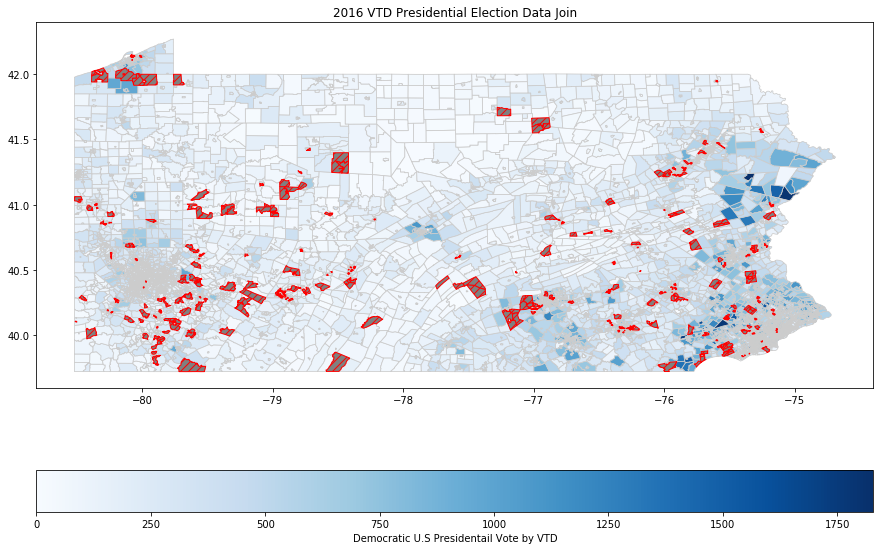

In [106]:
ax = df16[df16.DEM_USP16.notna()].plot(column='DEM_USP16', figsize=(15, 10), cmap='Blues', edgecolor='0.8', linewidth=0.8, 
                           legend=True, legend_kwds={'label': "Democratic U.S Presidentail Vote by VTD",
                                                     'orientation': "horizontal"})

df16[df16.DEM_USP16.isna()].plot(color='grey', hatch='///', ax=ax, edgecolor="red",
                     legend_kwds={'label': "Missing Data",
                                                     'orientation': "horizontal"})
plt.title("2016 VTD Presidential Election Data Join");

In [107]:
# Clean final dataset - reorder columns
df16 = df16[['STATEFP10', 'COUNTYFP10', 'VTDST10', 'GEOID10', 'VTDI10', 'NAME10',
       'NAMELSAD10', 'PA_GEO_ID', 'PA_VOTE_ID','precinct','county', 'municipality', 
        'vtd','vtd_id', 'district', 'NAME','LSAD10', 'MTFCC10', 'FUNCSTAT10', 
        'ALAND10', 'AWATER10','INTPTLAT10', 'INTPTLON10', 'geometry', 
        'TOTPOP', 'NH_WHITE','NH_BLACK', 'NH_AMIN ', 'NH_ASIAN', 'NH_NHPI ', 'NH_OTHER', 
        'NH_2MORE','HISP', 'VAP','HVAP', 'WVAP', 'BVAP','AMINVAP', 'ASIANVAP', 'NHPIVAP', 
        'OTHERVAP', '2MOREVAP','GOVDV2010', 'GOVRV2010','USSDV2010', 'USSRV2010', 
        'DEM_ATT12', 'DEM_USP12', 'DEM_USS12','REP_ATT12', 'REP_USP12', 'REP_USS12', 
        'THIRD_USP12', 'THIRD_ATT12','THIRD_USS12', 'DEM_GOV14','REP_GOV14',
        'DEM_ATT16', 'DEM_USP16', 'DEM_USS16', 'REP_ATT16', 'REP_USP16','REP_USS16']]

In [108]:
## Save final shapefile
# df16.to_file("PA_MGGG_replication.shp")

## Validate - Load MGGG VA shapefile to compare results

In [109]:
gdf = gpd.read_file('./MGGG-final/PA_VTDs/PA_VTD_PLANS.shp')

In [110]:
validate = pd.merge(gdf, df16, on="GEOID10", how="inner", indicator=True)

### _2010 data_

In [111]:
validate.SEN10D = validate.round(0)["SEN10D"]
validate.SEN10R = validate.round(0)["SEN10R"]

validate.SEN10D = validate.SEN10D.astype(int)
validate.SEN10R = validate.SEN10R.astype(int)

validate['sen10_dem_vote_dff'] = validate.USSDV2010 - validate.SEN10D
validate['sen10_rep_vote_dff'] = validate.USSRV2010 - validate.SEN10R

**91% of VTDs have a vote deviation of 50 or less for both parties - 2010 Senate Election**

In [112]:
validate[(validate.sen10_dem_vote_dff.abs()<=50) & (validate.sen10_rep_vote_dff.abs()<=50)].shape[0] / validate.shape[0]

0.9148568341437061

### _2012 data_

In [113]:
validate.PRES12D = validate.round(0)["PRES12D"]
validate.PRES12R = validate.round(0)["PRES12R"]

validate.PRES12D = validate.PRES12D.astype(int)
validate.PRES12R = validate.PRES12R.astype(int)

validate['pres12_dem_vote_dff'] = validate.DEM_USP12 - validate.PRES12D
validate['pres12_rep_vote_dff'] = validate.REP_USP12 - validate.PRES12R

**91% of VTDs have a vote deviation of 50 or less for both parties - 2012 Presidential Election**

In [114]:
validate[(validate.pres12_dem_vote_dff.abs()<=50) & (validate.pres12_rep_vote_dff.abs()<=50)].shape[0] / validate.shape[0]

0.9139924365207995

### _2014 data_

In [115]:
validate.F2014GOVD = validate.round(0)["F2014GOVD"]
validate.F2014GOVR = validate.round(0)["F2014GOVR"]

validate.F2014GOVD = validate.F2014GOVD.astype(int)
validate.F2014GOVR = validate.F2014GOVR.astype(int)

validate['gov14_dem_vote_dff'] = validate.DEM_GOV14 - validate.F2014GOVD
validate['gov14_rep_vote_dff'] = validate.REP_GOV14 - validate.F2014GOVR

**90% of precincts have a vote deviation of 50 or less for both parties - 2014 Gov. Election**

In [116]:
validate[(validate.gov14_dem_vote_dff.abs()<=50) & (validate.gov14_rep_vote_dff.abs()<=50)].shape[0] / validate.shape[0]

0.8996218260399784

### _2016 data_

In [117]:
validate.T16PRESD = validate.round(0)["T16PRESD"]
validate.T16PRESR = validate.round(0)["T16PRESR"]

validate.T16PRESD = validate.T16PRESD.astype(int)
validate.T16PRESR = validate.T16PRESR.astype(int)

validate['pres16_dem_vote_dff'] = validate.DEM_USP16 - validate.T16PRESD
validate['pres16_rep_vote_dff'] = validate.REP_USP16 - validate.T16PRESR

**86% of precincts have a vote deviation of 50 or less for both parties - 2016 Presidential Election**

In [118]:
validate[(validate.pres16_dem_vote_dff.abs()<=50) & (validate.pres16_rep_vote_dff.abs()<=50)].shape[0] / validate.shape[0]

0.8581307401404646

#### Which of the 2016 missing values in presidential vote are 0.0 is MGGG's shapefile??

In [119]:
import math
validate[validate.PRES12D==0.0][["GEOID10","NAME10_x", "PRES12R", "PRES12D","REP_USP16","DEM_USP16" ]].sort_values("NAME10_x")

check = []
for i,j,k,l in zip(validate.PRES12R,validate.PRES12D, validate.REP_USP16,validate.DEM_USP16):
    if i==0.0 and j==0.0 and math.isnan(k) and math.isnan(l): 
        check.append(1)
    else:
        check.append(0)
        
validate['check'] = check
# check=1 --- NaN in df16 is 0.0 in MGGG's
# check=0 --- NaN in df16 is not 0.0 in MGGG's


**Nearly 100 VTDs in the df16 dataframe that are NaN for Presidential vote are 0.0 in MGGG's shapeifle**

In [120]:
sum(check)

98

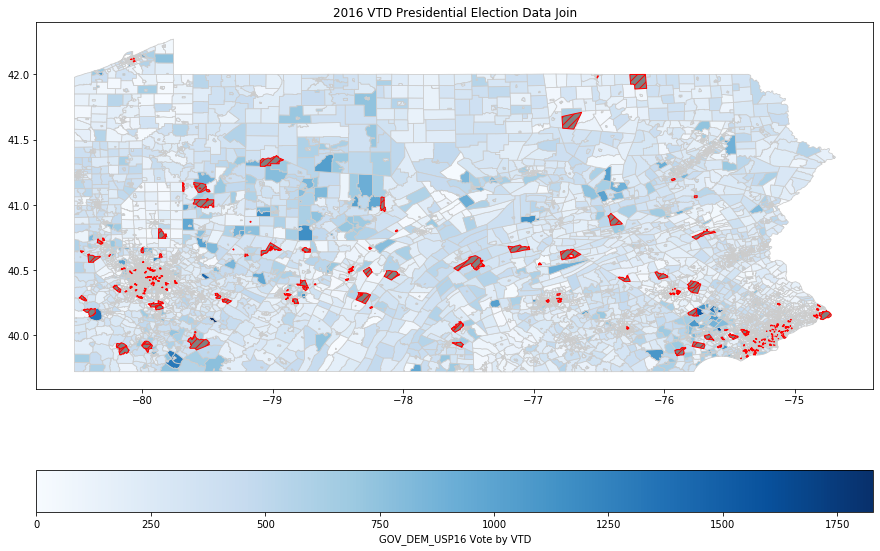

In [121]:
# Final Map with select NaNs replaced with 0.0 for presidential vote 

update_DPRES14_votes = []
for i,j in zip(validate.check, validate.DEM_USP16):
    if i==1:
        update_DPRES14_votes.append(0.0)
    elif math.isnan(j):
        update_DPRES14_votes.append(np.nan)
        
    else:
        update_DPRES14_votes.append(j)

df16['DEM_USP16_mggg0s'] = update_DPRES14_votes

ax = df16[df16.DEM_USP16_mggg0s.notna()].plot(column='DEM_USP16_mggg0s', figsize=(15, 10), cmap='Blues', edgecolor='0.8', linewidth=0.8, 
                           legend=True, legend_kwds={'label': "GOV_DEM_USP16 Vote by VTD",
                                                     'orientation': "horizontal"})

df16[df16.DEM_USP16_mggg0s.isna()].plot(color='grey', hatch='///', ax=ax, edgecolor="red",
                     legend_kwds={'label': "Missing Data",
                                                     'orientation': "horizontal"})
plt.title("2016 VTD Presidential Election Data Join");

### _Population data_

In [122]:
validate.TOTPOP_x = validate.TOTPOP_x.astype(int)
validate.TOTPOP_y = validate.TOTPOP_y.astype(int)

validate['pop_diff'] = validate.TOTPOP_x - validate.TOTPOP_y

**99% of VTDs have a population deviation of 1 person or less**

In [123]:
validate[validate.pop_diff.abs()<1].shape[0] / validate.shape[0]

0.9966504592112372

**99% of VTDs have a black population deviation of 1 person or less**

In [124]:
validate.NH_BLACK_x = validate.NH_BLACK_x.astype(int)
validate.NH_BLACK_y = validate.NH_BLACK_y.astype(int)

validate['bpop_diff'] = validate.NH_BLACK_x - validate.NH_BLACK_y

In [125]:
validate[validate.bpop_diff.abs()<1].shape[0] / validate.shape[0]

0.9991356023770934

**99% of VTDs have a black voting age population deviation of 1 person or less**

In [126]:
validate['bvap_diff'] = validate.BVAP_x - validate.BVAP_y

validate[validate.bvap_diff.abs()<1].shape[0] / validate.shape[0]

0.9990275526742302